# FluxCourse SIF section (1)

## Introduction

In this section, we will learn the basics of SIF emission from leaves, including:

* Understand the shape of fluorescence emission (using the data you collected)
* Understand that light intensity as the major control of SIF emission
* Retrieve SIF from an outdoor environment

What we learn here is a mini-version of what has been down with satellite, airborne, or ground-based remote sensing instruments. Hopefully with this hands-on practice you will gain some basic understandings of remote sensing data processing.

## Logistics


You will need to collect the raw digital number from the "SIF magic box" experiment. We will convert these DN to radiance. You will need the following packages. Remember to install the packages using "conda install [package-name]" in your command line:

* pandas
* numpy
* matplotlib
* glob
* xlrd
* scipy

## Reference

Shameless self-promotion ;)

Yang, X., Shi, H., Stovall, A., Guan, K., Miao, G., Zhang, Y., Zhang, Y., Xiao, X., Ryu, Y. and Lee, J.E., 2018. [FluoSpec 2—An Automated Field Spectroscopy System to Monitor Canopy Solar-Induced Fluorescence.](https://www.mdpi.com/1424-8220/18/7/2063/pdf-vor) Sensors, 18(7), p.2063.

Yang, X., Tang, J., Mustard, J.F., Lee, J.E., Rossini, M., Joiner, J., Munger, J.W., Kornfeld, A. and Richardson, A.D., 2015. [Solar‐induced chlorophyll fluorescence that correlates with canopy photosynthesis on diurnal and seasonal scales in a temperate deciduous forest.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015GL063201) Geophysical Research Letters, 42(8), pp.2977-2987.

**Import packages (usually the first step)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy
from matplotlib.backends.backend_pdf import PdfPages

# import the leaf sif tool I wrote
from leaf_SIF_tools import *

### Let's read one spectra file we've just collected
We will read the spectra, which is in raw DN, uncalibrated. We will then visualize it

In [14]:
# Change the filename to the file you want to read. Pick one yourself from the light folder
filename         = '/Users/xiyang/Documents/GitHub/FluxCourse/Data/light/QEP013861_16-40-50-489.txt'
# Take a look at the function read_rawspec in leaf_SIF_tools.py
# read_rawspec reads the files you just collected, and the output
# are df, which is a DataFrame of your spectrum, and ITdf, which is
# the integration time of the spectrum you just collected. For ITdf,
# the first column is the placeholder, and you use the second column
filename1        = open(filename,'r')
lines            = filename1.readlines()
df,ITdf          = read_rawspec(filename)

You can print out the spectrum and IT

In [ ]:
display(df)
display(ITdf)

How about plot it?

In [ ]:
plt.plot(df['wavelength'],df.iloc[:,1])
plt.xlabel('wavelength(nm)')
plt.ylabel('Digital Number(DN)')
plt.show()

This is one of the raw fluorescence spectra you just collected! Congratulations! Now, take a look at the spectrum here and summarize what you see.

During the experiment, we collected a lot of spectra, and we also collected some "dark" spectra. The actual signal coming from the leaves are the difference between the "light" and "dark" measurements. Let's take a look at them separately, and the calculate the actual signal with them.

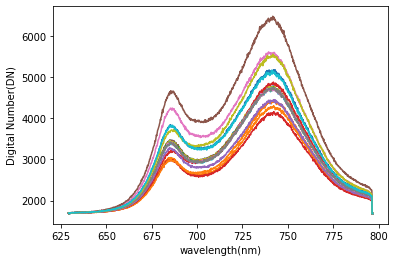

In [17]:
# In this example, I have twenty "light" spectra and ten "dark" spectra. 
# Let's plot "light" spectra
lightfiles      = '/Users/xiyang/Documents/GitHub/FluxCourse/Data/light/*.txt'
df2,ITdf2       = read_rawspec(lightfiles)
plt.plot(df2['wavelength'],df2.iloc[:,1:])
plt.xlabel('wavelength(nm)')
plt.ylabel('Digital Number(DN)')
plt.show()

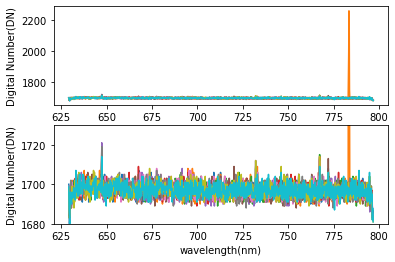

In [21]:
# Let's plot "dark" spectra
darkfiles       = '/Users/xiyang/Documents/GitHub/FluxCourse/Data/dark/*.txt'
df3,ITdf3       = read_rawspec(darkfiles)

plt.subplot(2,1,1)
plt.plot(df3['wavelength'],df3.iloc[:,1:])
plt.ylabel('Digital Number(DN)')

plt.subplot(2,1,2)
plt.plot(df3['wavelength'],df3.iloc[:,1:])
plt.xlabel('wavelength(nm)')
plt.ylabel('Digital Number(DN)')

plt.ylim([1680,1730])
plt.show()

**What do we see here?**


1) Dark current is the electric noise of the spectrometer, it is fairly constant during measurements (consider the variation in dark current vs. the magnitude and variation of light measurements).

2) There are some pixels that has random yet much bigger noise, but in reality we don't need to worry about it too much, for two reasons: usually there are only 1-2 pixels (out of 1044 pixels) that may have a "spike" in dark signal; the magnitude of the spike is still very small compared with the signal you get from leaves.

### Radiometric calibration: converting raw data to values with physical meanings

The next step is essential in most circumstances in remote sensing. We will convert unitless DN values to radiance in the unit of mw/m2/nm/sr, exactly the same as the unit of data from those SIF satellite sensors (OCO-2, TROPOMI etc.) 

Usually this process involves some calibration factor that you get from the manufacturer, or you collect yourself. In this practice, I provide you with the calibration factor for this spectrometer we are using: "/Users/xiyang/Documents/GitHub/FluxCourse/Data/20190521/QEP013861_20190521_ConversionFactor_L_VEG.xlsx". There are three calibration factors, each in one column of this file, collected under a certain integration time. You can find these integration time in the tab "int_time". Let's plot them.

In [22]:
calib_factor = pd.read_excel('/Users/xiyang/Documents/GitHub/FluxCourse/Data/20190521/QEP013861_20190521_ConversionFactor_L_VEG.xlsx',sheet_name='cov_cor',header=None)
calib_wl     = pd.read_excel('/Users/xiyang/Documents/GitHub/FluxCourse/Data/20190521/QEP013861_20190521_ConversionFactor_L_VEG.xlsx',sheet_name='wl',header=None)
calib_int    = pd.read_excel('/Users/xiyang/Documents/GitHub/FluxCourse/Data/20190521/QEP013861_20190521_ConversionFactor_L_VEG.xlsx',sheet_name='int_time',header=None)
#calib_int needs to be converted from ms to s by multiplying 0.001
calib_int    = calib_int*0.001

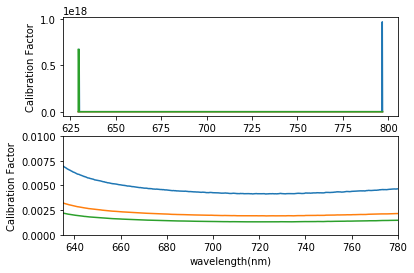

In [24]:
plt.subplot(2,1,1)
plt.plot(calib_wl,calib_factor)
plt.ylabel('Calibration Factor')
plt.subplot(2,1,2)
plt.plot(calib_wl,calib_factor)
plt.xlabel('wavelength(nm)')
plt.ylabel('Calibration Factor')
plt.xlim([635,780])
plt.ylim([0,0.01])
plt.show()

**What is going on at the beginning and the end of the spectra??**

Spectrometers are designed in a way that they have some pixels that serve as the "baseline" of the electronic performance of spectrometers, and they are located at the beginning and end of the electronic detectors (pixels). We will exclude them in the future analysis (first 10 and last 10).

**How to convert DN to Radiance??**

DN values (actual signal) are generally linearly correlated with the integration time. That is the longer the integration time, the higher the DN is. Thus we can use the following equation to calculate radiance:

Radiance = (Light - Dark) * Calibration Factor * (INT2/INT1), where INT1 is the integration time of the actual measurement, where as INT2 is the integration time of the calibration factor. You can pick one of the calibration factors (why?).

I have written a function to convert the data you collected (DN values, light-dark) to Radiance. The syntax is:

Radiance = DNtoRad(light,dark,intTime,calib_factor,calib_intTime)
* light: one spectrum of the object (leaf or panel)
* dark: dark current
* intTime: integration time of your measurement
* calib_factor: calibration factor we read. Pick one of the three (any of them)
* calib_intTime: calibration integration time.
* Radiance: the output radiance of the object

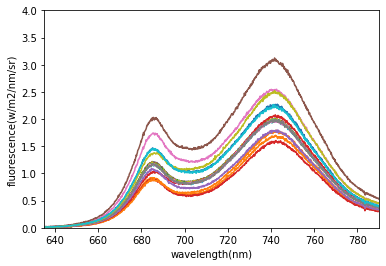

In [25]:
# The signal is calculated as signal = light - mean(dark); 
SIF_radiance     = np.ndarray(shape=(len(df2),len(df2.columns)-1))
for ii in range(len(df2.columns)-1):
    light              = df2.iloc[:,ii+1]
    dark               = df3.iloc[:,1:].mean(axis=1)
    intTime            = ITdf2.iloc[:,1] 
    cal_factor         = calib_factor.iloc[:,2]
    cal_intTime        = calib_int.iloc[:,2]
    SIF_radiance[:,ii] = DNtoRad(light,dark,intTime,cal_factor,cal_intTime)

plt.plot(df3['wavelength'],SIF_radiance)
plt.xlim([635,790])
plt.ylim([0,4])
plt.xlabel('wavelength(nm)')
plt.ylabel('fluorescence(w/m2/nm/sr)')
plt.show()

Satellites usually retrieve SIF from the near-infrared region (700 nm and beyond), with the exception that Dr. Joiner (NASA GSFC) has estimated red SIF from GOME-2. OCO-2 gives you SIF at 771 nm and 757 nm, while TROPOMI gives you SIF at 740 nm. FLEX mission has the potential to provide SIF estimates at ~680 nm at ~760 nm.

You can compare the magnitude of the SIF signal you measured with satellites' SIF estimation later in this session.

## Outdoor measurements and calculating SIF from the raw data

Outdoor measurements of SIF are different and more difficult than the indoor measurements you've just done. Why?

In this section, you will learn how to retrieve SIF from outdoor leaf-level and/or canopy-level measurements. The goal is to introduce the basis of all kinds of SIF retrieval methods, including those that are used by satellites. We are not going to cover the details of all methods, but instead providing a basic understanding of the retrieval. After this section, hopefully you will gain insights in how SIF is being estimated from satellite or ground observations, and the potential uncertainties.


In [26]:
# put the folder names of your measurements

referencefiles  = '/Users/xiyang/Documents/GitHub/FluxCourse/Data/outdoor/light/reference/*.txt'
df_od1,IT_od1   = read_rawspec(referencefiles)
leaffiles       = '/Users/xiyang/Documents/GitHub/FluxCourse/Data/outdoor/light/leaves/*.txt'
df_od2,IT_od2   = read_rawspec(leaffiles)
darkfiles       = '/Users/xiyang/Documents/GitHub/FluxCourse/Data/outdoor/dark/*.txt'
df_od3,IT_od3   = read_rawspec(darkfiles)

Take a look at the spectra you measured. Change the variable name to leaf or dark files if you want

In [ ]:
display(df_od1)

The next step is to convert DN to radiance. Feel free to modify plt. code to show the spectrum  (or spectra) you want to see.

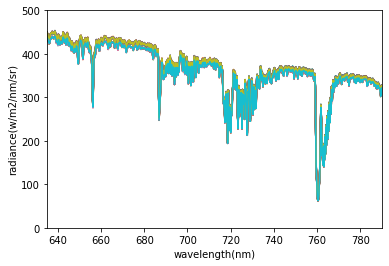

In [32]:
panel_radiance           = np.ndarray(shape=(len(df_od1),len(df_od1.columns)-1))
for jj in range(len(df_od1.columns)-1):
    light                = df_od1.iloc[:,jj+1]
    dark                 = df_od3.iloc[:,1:].mean(axis=1)
    intTime              = IT_od1.iloc[:,1] 
    cal_factor           = calib_factor.iloc[:,2]
    cal_intTime          = calib_int.iloc[:,2]
    panel_radiance[:,jj] = DNtoRad(light,dark,intTime,cal_factor,cal_intTime)

leaf_radiance            = np.ndarray(shape=(len(df_od2),len(df_od2.columns)-1))
for kk in range(len(df_od2.columns)-1):
    light                = df_od2.iloc[:,kk+1]
    dark                 = df_od3.iloc[:,1:].mean(axis=1)
    intTime              = IT_od2.iloc[:,1] 
    cal_factor           = calib_factor.iloc[:,2]
    cal_intTime          = calib_int.iloc[:,2]
    leaf_radiance[:,kk]  = DNtoRad(light,dark,intTime,cal_factor,cal_intTime)

plt.plot(df3['wavelength'],panel_radiance)
#plt.plot(df3['wavelength'],leaf_radiance)
plt.xlim([635,790])
plt.ylim([0,500])
plt.xlabel('wavelength(nm)')
plt.ylabel('radiance(w/m2/nm/sr)')
plt.show()

What do we see here? Can you summarize the key features of the spectra you collected? Do they tell you the magnitude of SIF as intuitively as the indoor measurements? Why not?

One way I usually use to check whether there is a SIF signal is to calculate the reflectance of the leaf:

Reflectance = Leaf / (Panel * Pi)  <-- why Pi?

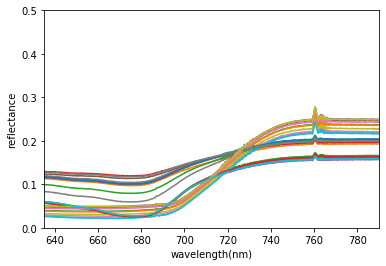

In [33]:
mean_panel  = np.mean(scipy.pi*panel_radiance,axis=1)
reflectance = np.divide(leaf_radiance[:,],mean_panel[:,None])
plt.plot(df3['wavelength'],reflectance)
plt.xlim([635,790])
plt.ylim([0,0.5])
plt.xlabel('wavelength(nm)')
plt.ylabel('reflectance')
plt.show()

What do you see here? Let's zoom in and take a look at the O2A band region (~760 nm).

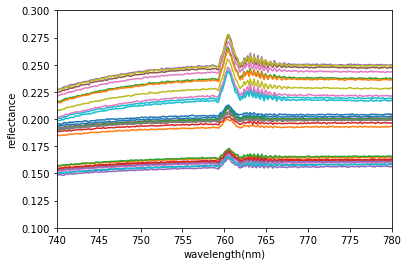

In [35]:
plt.plot(df3['wavelength'],reflectance)
plt.xlim([740,780])
plt.ylim([0.1,0.3])
plt.xlabel('wavelength(nm)')
plt.ylabel('reflectance')
plt.show()

We can visualize each individual spectrum and plot them in PDF

In [36]:
SIF = np.empty(len(df_od2.columns)-1)
SIF_images = '/Users/xiyang/Documents/GitHub/FluxCourse/Data/SIF.pdf'
PDF1= PdfPages(SIF_images)

for kkk in range(len(df_od2.columns)-1):
    
    (SIF[kkk],fig)=SIF_SFM(leaf_radiance[:,kkk],mean_panel,df3['wavelength'])
    PDF1.savefig(fig)
    fig.clear()
    fig.clf()
    
PDF1.close()  

**Hooray! Congratulations! You have made your first SIF retrieval!**